<a href="https://colab.research.google.com/github/papagorgio23/Python101/blob/master/Py_202_F%2B_Model_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing Library
!pip install pydata_google_auth

In [ ]:
# import base packages into the namespace for this program
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport

# F+ Lead Scoring Model

![NPV Model](https://raw.githubusercontent.com/papagorgio23/Python101/master/NPV%20Model.png)

## Get Data

In [ ]:
# Using GBQ shout Out to Hughes
import pandas_gbq
import pydata_google_auth

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

# get credentials
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=False)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=nVO0MRq6ceZkMDyp4yqNu84lNsq6De&prompt=consent&access_type=offline
Enter the authorization code: 4/sAHzOUvhqBDTTbFzh6dalmdHTnC_40d-UIk0OstK3byRehyU735PsZo


In [ ]:
# GBQ
sql = """
SELECT 
  id
, co_app_verifiable_annual_income__c
, loan_use__c
, employment_status__c
, amount_of_loan_requested__c
, fico__c
, lti__c
, bcc0300__c
, ndi_ratio__c
, utm_source__c
, CASE WHEN date_funded__c IS NOT NULL THEN 1 ELSE 0 END AS Fund

FROM `freedom-dw.salesforce_ffam.application__c` a 

WHERE createddate >= '2019-07-01'
AND a.loan_officer__c  IS NOT NULL
"""

In [ ]:
# run query
fplus_df = pandas_gbq.read_gbq(sql, project_id='ffn-dw-bigquery-prd', credentials=credentials, dialect='standard')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=495642085510-k0tmvj2m941jhre2nbqka17vqpjfddtd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=itYZ2IhTZtgiiyzIGt27X6NLt3kt3t&prompt=consent&access_type=offline
Enter the authorization code: 4/sAH_ofoqm6sa-9jNj0O7dIXDbq1l-5OzmugfAcQPDkzU6eGRxO9L6VI


## View Data

In [ ]:
# view top 5 observations
fplus_df.head()

,id,co_app_verifiable_annual_income__c,loan_use__c,employment_status__c,amount_of_loan_requested__c,fico__c,lti__c,bcc0300__c,ndi_ratio__c,utm_source__c,Fund
0,a010f00000YmfOeAAJ,NaN,Credit Card Refinancing,Full-time,50000.0,692.0,26.7,27.0,44.400000,Lending Tree,0
1,a010f00000ZAkpmAAD,NaN,Credit Card Refinancing,Self-employed,30000.0,771.0,30.6,27.0,42.400000,Lending Tree,0
2,a010f00000YQQoJAAX,44500.0,Credit Card Refinancing,Retired,25000.0,631.0,31.1,34.0,39.300000,msn,0
3,a010f00000Wjj5AAAR,65000.0,Debt Consolidation,Self-employed,35000.0,752.0,25.4,25.0,32.983773,Lending Tree,0
4,a010f00000ZTM4BAAX,NaN,Credit Card Refinancing,Other,40000.0,684.0,13.3,30.0,38.600000,Lending Tree,0


In [ ]:
# view bottom 5 observations
fplus_df.tail()

,id,co_app_verifiable_annual_income__c,loan_use__c,employment_status__c,amount_of_loan_requested__c,fico__c,lti__c,bcc0300__c,ndi_ratio__c,utm_source__c,Fund
176914,a010f00000Y4XmGAAV,80000.0,Debt Consolidation,Full-time,50000.0,783.0,25.3,1.0,18.200000,Lending Tree,0
176915,a010f00000XfO5PAAV,NaN,Debt Consolidation,Full-time,29999.0,507.0,34.9,1.0,67.000000,Phone,0
176916,a010f00000ZB3hXAAT,49000.0,Home Improvement,Other,10000.0,654.0,15.7,1.0,40.600000,Lending Tree,0
176917,a010f00000Y3DfVAAV,NaN,Other,Full-time,13000.0,737.0,3.0,1.0,5.374026,Lending Tree,0
176918,a010f00000YQdVVAA1,NaN,Business Expenses,Full-time,10000.0,648.0,16.7,1.0,34.500000,Lending Tree,1


In [ ]:
# view columns, data types
fplus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176919 entries, 0 to 176918
Data columns (total 11 columns):
id                                    176919 non-null object
co_app_verifiable_annual_income__c    37689 non-null float64
loan_use__c                           175782 non-null object
employment_status__c                  175712 non-null object
amount_of_loan_requested__c           176056 non-null float64
fico__c                               173823 non-null float64
lti__c                                175020 non-null float64
bcc0300__c                            173823 non-null float64
ndi_ratio__c                          173785 non-null float64
utm_source__c                         176919 non-null object
Fund                                  176919 non-null int64
dtypes: float64(6), int64(1), object(4)
memory usage: 14.8+ MB


In [ ]:
# get summary statistics
fplus_df.describe()

,co_app_verifiable_annual_income__c,amount_of_loan_requested__c,fico__c,lti__c,bcc0300__c,ndi_ratio__c,Fund
count,3.768900e+04,176056.000000,173823.000000,175020.000000,173823.000000,173785.000000,176919.000000
mean,8.001714e+04,21900.385159,715.205364,27.123215,7.498104,39.592446,0.100396
std,2.209551e+06,11864.666616,169.122159,2157.111508,5.280425,18.772559,0.300528
min,-2.029000e+03,0.000000,433.000000,0.000000,0.000000,0.000000,0.000000
25%,3.456000e+04,12500.000000,675.000000,14.300000,4.000000,28.900000,0.000000
50%,5.209500e+04,19000.000000,707.000000,20.000000,6.000000,37.900000,0.000000
75%,7.800000e+04,30000.000000,746.000000,27.400000,10.000000,48.600000,0.000000
max,4.193395e+08,400000.000000,9003.000000,899900.000000,99.000000,2246.900000,1.000000


In [ ]:
# check NA
fplus_df.isna().sum()

id                                         0
co_app_verifiable_annual_income__c    139230
loan_use__c                             1137
employment_status__c                    1207
amount_of_loan_requested__c              863
fico__c                                 3096
lti__c                                  1899
bcc0300__c                              3096
ndi_ratio__c                            3134
utm_source__c                              0
Fund                                       0
dtype: int64

# Investigate Variables

## 1) - Co App

We only care if an application has a Co App with them. We are using co_app_verifiable_annual_income__c to let us know if they have one. 

<br>

*   If NA then No Co App
*   If Not NA then Co App

<br>

### View data

In [ ]:
# drop na for co app and view distribution
co_app = fplus_df.dropna(subset=['co_app_verifiable_annual_income__c'])

In [ ]:
co_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37689 entries, 0 to 176916
Data columns (total 12 columns):
id                                    37689 non-null object
co_app_verifiable_annual_income__c    37689 non-null float64
loan_use__c                           37663 non-null object
employment_status__c                  37686 non-null object
amount_of_loan_requested__c           37686 non-null float64
fico__c                               37328 non-null float64
lti__c                                37556 non-null float64
bcc0300__c                            37328 non-null float64
ndi_ratio__c                          37291 non-null float64
utm_source__c                         37689 non-null object
Fund                                  37689 non-null int64
co_app                                37689 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 3.7+ MB


In [ ]:
co_app.describe()

,co_app_verifiable_annual_income__c,amount_of_loan_requested__c,fico__c,lti__c,bcc0300__c,ndi_ratio__c,Fund,co_app
count,3.768900e+04,37686.000000,37328.000000,37556.00000,37328.000000,37291.000000,37689.000000,37689.0
mean,8.001714e+04,24757.760988,720.284478,20.22022,6.994642,37.401085,0.176895,1.0
std,2.209551e+06,12583.048943,232.918382,14.27604,5.105449,22.648286,0.381585,0.0
min,-2.029000e+03,0.000000,433.000000,0.00000,0.000000,0.000000,0.000000,1.0
25%,3.456000e+04,15000.000000,675.000000,13.10000,4.000000,25.931489,0.000000,1.0
50%,5.209500e+04,20000.000000,710.000000,18.80000,6.000000,33.926455,0.000000,1.0
75%,7.800000e+04,33500.000000,749.000000,25.70000,9.000000,44.400000,0.000000,1.0
max,4.193395e+08,191000.000000,9003.000000,1100.10000,99.000000,1499.300000,1.000000,1.0


### Plot

[Text(0.5, 0, '')]

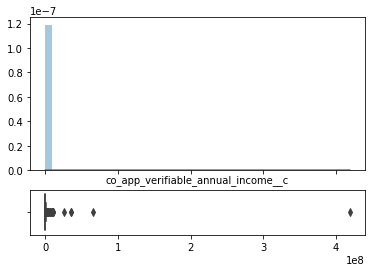

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(co_app['co_app_verifiable_annual_income__c'], ax=ax_box)
sns.distplot(co_app['co_app_verifiable_annual_income__c'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

### Remove outliers

In [ ]:
## remove outlier...
co_app = co_app[co_app['co_app_verifiable_annual_income__c'] < 200000]

[Text(0.5, 0, '')]

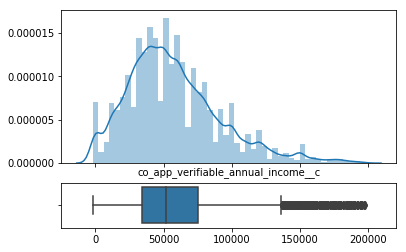

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(co_app['co_app_verifiable_annual_income__c'], ax=ax_box)
sns.distplot(co_app['co_app_verifiable_annual_income__c'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [ ]:
def get_co_app_cat(co_app_income):
    """This function creates a Co-App Flag"""
    if pd.isnull(co_app_income):
        return 0
    return 1

In [ ]:
# apply function to dataset
fplus_df['co_app'] = fplus_df['co_app_verifiable_annual_income__c'].apply(get_co_app_cat)

In [ ]:
# view counts now
fplus_df['co_app'].value_counts()

0    139230
1     37689
Name: co_app, dtype: int64

In [ ]:
# view percentage
fplus_df['co_app'].value_counts()/len(fplus_df)

0    0.78697
1    0.21303
Name: co_app, dtype: float64

### How does Co-App affect Funding?

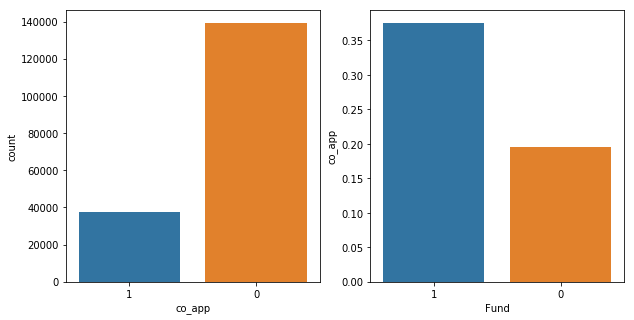

In [ ]:
# plot 2 barplots, 1 showing total counts, 1 showing co app percent by fund
fig, (axis1,axis2) = plt.subplots(1,2, sharex=True, figsize=(10,5))

# barplot
sns.countplot(x='co_app', data=fplus_df, order=[1,0], ax=axis1)

# Get Fund rate for Co-App vs No Co-App
fund_perc = fplus_df[["Fund", "co_app"]].groupby(['Fund'], as_index=False).mean()
sns.barplot(x='Fund', y='co_app', data=fund_perc, order=[1,0], ax=axis2)

## 2) - Loan to Income (LTI)

### View Data

In [ ]:
# drop na for lti and view distribution
loan_income = fplus_df.dropna(subset=['lti__c'])

In [ ]:
loan_income['lti__c'].describe()

count    175020.000000
mean         27.123215
std        2157.111508
min           0.000000
25%          14.300000
50%          20.000000
75%          27.400000
max      899900.000000
Name: lti__c, dtype: float64

[Text(0.5, 0, '')]

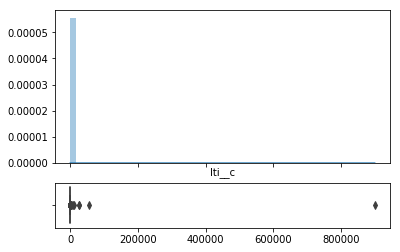

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(loan_income['lti__c'], ax=ax_box)
sns.distplot(loan_income['lti__c'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

### Remove Outliers

In [ ]:
744/139230

0.005343675931911226

## 3) - Marketing Channel (utm_source)

In [ ]:
# Cross tab
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(fplus_df['utm_source__c'], fplus_df['Fund'], values=fplus_df['Fund'], aggfunc=[len, np.mean], margins=True, margins_name="Total").style.background_gradient(cmap = cm)

NameError: ignored

In [ ]:
# pivot table
def fund_rate(x):
  '''This function is used within pivot_tables to calculate ratios'''
  return np.sum(x) / np.size(x)

pivoting = pd.pivot_table(fplus_df, values='Fund', index='utm_source__c',
              aggfunc={'Fund': [np.sum, np.size, fund_rate]})

print(pivoting.sort_values('size', ascending=False).to_string())

## 4) - FICO

## 5) - Employment

## 6) - Debt to Income (NDI)

## 7) - Debt to Income Squared

## 8) - Loan Use

## 9) - Bank Card Trades (bcc0300)

## 10) - Loan Amount

# Prediction Model

In [ ]:
model_data = fplus_df.dropna()

In [ ]:
def get_co_app_cat(co_app_income):
    
    if pd.isnull(co_app_income):
        return 0
    return 1

model_data['co_app_verifiable_annual_income__c'] = model_data['co_app_verifiable_annual_income__c'].apply(get_co_app_cat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [ ]:
# create dummies
cat_vars = ['loan_use__c','employment_status__c','utm_source__c']
for var in cat_vars:
    cat_list = pd.get_dummies(model_data[var], prefix=var)
    temp = model_data.join(cat_list)
    model_data = temp
data_vars = model_data.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]
model_data = model_data[to_keep]

In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39509 entries, 2 to 187914
Columns: 109 entries, id to utm_source__c_yahoo
dtypes: float64(5), int64(2), object(1), uint8(101)
memory usage: 7.8+ MB


In [ ]:
model_data = model_data.drop(['id'], axis = 1)

In [ ]:
# segment out the variable we are predicting from the rest of the data
y = model_data['Fund']
X = model_data.drop(['Fund'], axis = 1)

# Split the data into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# 10 Fold Cross Validation. 
num_instances = len(X)
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

(31607, 107) (31607,)
(7902, 107) (7902,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Accuracy: 81.412% (2.394%)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


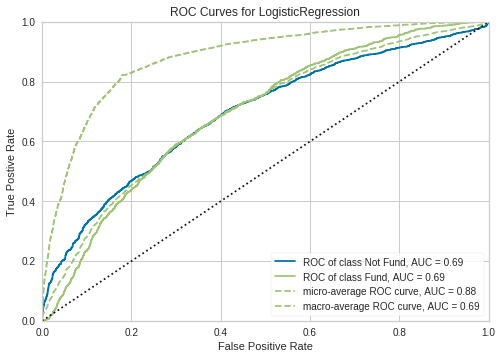

In [ ]:
# Set classes for all plots
classes = ['Not Fund', 'Fund']

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(model, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


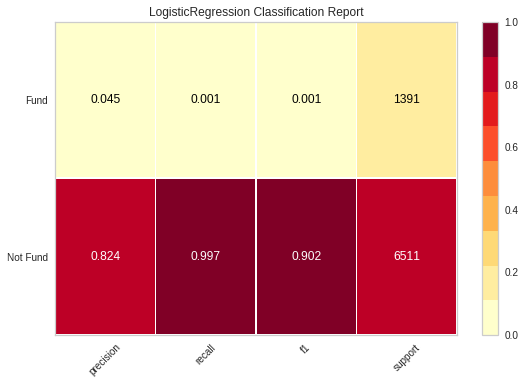

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## Data Transformation Functions

In [ ]:
import numpy as np
import pandas as pd

def get_co_app_cat(co_app_income):
    
    if pd.isnull(co_app_income):
        return 0
    return 1

def get_loan_use_cat(loan_use):
    
    if pd.isnull(loan_use):
        return 3
    
    loan_use = loan_use.strip()
    if (loan_use == 'Credit Card Refinancing'):
        return 4
    if (loan_use in ['Major Purchase','Other']):
        return 2
    if (loan_use == 'Auto Purchase'):
        return 1
    
    return 3

def get_employment_cat(employment_status):
    
    if pd.isnull(employment_status):
        employment_status = ''
    
    employment_status = employment_status.strip()
    if (employment_status == 'Retired'):
        return 4
    if (employment_status in ['Self-employed']):
        return 2
    if (employment_status in ['Other', '']):
        return 1
    
    return 3

def get_loan_amount_cat(loan_amount):
    
    if pd.isnull(loan_amount):
        return 1
    
    loan_amount = float(loan_amount)
    if (loan_amount < 15000):
        return 4
    if (loan_amount >= 15000) and (loan_amount < 20000):
        return 3
    if (loan_amount >= 20000) and (loan_amount < 25000):
        return 2
    
    return 1

def get_mkt_chan_cat(utm_source):
    
    if pd.isnull(utm_source):
        return 3
    
    utm_source = utm_source.strip()
    if (utm_source in ['creditkarma','nerdwallet']):
        return 7
    if (utm_source in ['credible','experian']):
        return 6
    if (utm_source in ['website', 'google','msn','ck','nerd',
                        '115','save','dm','SLH','201']):
        return 5
    if (utm_source in ['facebook', 'even','uplift','Quinstreet',
                       'Personalloanpro','113']):
        return 2
    if (utm_source in ['LendEDU', 'monevo','247','sfl']):
        return 1
    
    return 3

def get_fico(fico):
    
    if pd.isnull(fico):
        return 990
    
    fico = int(fico)
    if (fico >= 9000):
        return 990
    if fico < 600:
        return 990
    
    return fico

def get_lti(lti):
    
    if pd.isnull(lti):
        return 36
    
    lti = float(lti)
    if (lti > 35) or (lti < 1):
        return 36
    if (lti >= 1) and (lti < 2):
        return 35
    if (lti >= 2) and (lti < 3):
        return 34
    
    return np.floor(lti)

def get_bcc0300(bcc0300):
    
    if pd.isnull(bcc0300):
        return 99
    
    bcc0300 = int(bcc0300)
    if (bcc0300 >= 25):
        return 30
    
    return bcc0300

def get_ndi_ratio(ndi_ratio):
    
    if pd.isnull(ndi_ratio):
        return 5
    
    ndi_ratio = float(ndi_ratio)
    ndi_ratio = np.floor(ndi_ratio)
    
    if (ndi_ratio < 10):
        return 5
    if (ndi_ratio > 75):
        return 80
    
    return ndi_ratio  



In [ ]:
# Compute the correlation matrix
corr = model_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

NameError: ignored

In [ ]:

# select only numeric data 
num_data = fplus_df.select_dtypes(include='number')

# Compute the correlation matrix
corr = num_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


NameError: ignored